# PROJET RAKUTEN - (Données images)

## rapport de modélisation

#### importation des librairies

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

2024-10-11 10:22:33.791288: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 10:22:36.629123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 10:22:36.634364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 10:22:42.139751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Chargement des données

In [2]:
data_processed_path = '../data/processed/'

product_dict = {
    2583: "pool accessories",
    1560: "home furnishings and decoration",
    1300: "model making",
    2060: "home accessories and decorations",
    2522: "stationery",
    1280: "children's toys",
    2403: "literature series",
    2280: "non-fiction books",
    1920: "textile accessories and decorations",
    1160: "trading card games",
    1320: "nursery products",
    10: "foreign literature",
    2705: "historical literature",
    1140: "figurines",
    2582: "garden accessories and decorations",
    40: "video games",
    2585: "gardening accessories and tools",
    1302: "outdoor accessories",
    1281: "children's games",
    50: "gaming accessories",
    2462: "sets of gaming or video game accessories",
    2905: "downloadable video games",
    60: "video game consoles",
    2220: "pet accessories",
    1301: "articles for newborns and babies",
    1940: "food",
    1180: "figurines to paint and assemble"
}

generalized_dict = {
    2583: "pool and outdoor accessories",  # Consolidating "pool accessories" and "outdoor accessories"
    1560: "home furnishings and decoration",  # Already generalized
    1300: "model making",  # Specific category
    2060: "home furnishings and decoration",  # Similar to "home furnishings and decoration"
    2522: "stationery",  # Specific category
    1280: "children's toys and games",  # Consolidating "children's toys" and "children's games"
    2403: "books and literature",  # Generalizing "literature series" and other book categories
    2280: "books and literature",  # Same as above
    1920: "home textiles and decorations",  # Generalizing "textile accessories and decorations"
    1160: "trading card games",  # Specific category
    1320: "nursery and baby products",  # Consolidating with newborns and babies products
    10: "books and literature",  # Foreign literature falls under general books
    2705: "books and literature",  # Historical literature falls under books
    1140: "figurines and collectibles",  # Consolidating with similar figurines
    2582: "garden and outdoor accessories",  # Consolidating garden-related items
    40: "video games and consoles",  # Consolidating all video game categories
    2585: "garden and outdoor accessories",  # Same as above
    1302: "pool and outdoor accessories",  # Consolidated under outdoor accessories
    1281: "children's toys and games",  # Merged with children's toys
    50: "video games and consoles",  # Part of video game accessories
    2462: "video games and consoles",  # Consolidating game-related accessories
    2905: "video games and consoles",  # Downloadable games fall under the general gaming category
    60: "video games and consoles",  # Game consoles
    2220: "pet accessories",  # Specific category
    1301: "nursery and baby products",  # Consolidating with nursery products
    1940: "food",  # Specific category
    1180: "figurines and collectibles"  # Merged with figurines category
}


df = pd.read_csv(data_processed_path+'X_y_train_balanced_2000.csv')

if df['prdtypecode'].dtype == np.int64:
    df['prdtypecode'] = df['prdtypecode'].map(generalized_dict)
    
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46004 entries, 0 to 46003
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   46004 non-null  object
 1   prdtypecode  46004 non-null  object
dtypes: object(2)
memory usage: 718.9+ KB


,image_path,prdtypecode
0,../data/raw/images/image_train/image_938777978...,video games and consoles
1,../data/raw/images/image_train/image_111008924...,figurines and collectibles
2,../data/raw/images/image_train/image_948608572...,video games and consoles
3,../data/raw/images/image_train/image_131614732...,video games and consoles
4,../data/raw/images/image_train/image_109231331...,figurines and collectibles


### Pretraitement et split du jeu de données

In [3]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
val_df = df.drop(train_df.index)                 # 20% for validation

# Parameters for data loading
image_size = (128, 128)  # Size to resize images (e.g., 224x224)
batch_size = 64          # Number of images per batch
class_mode = 'categorical'

# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',       # Column with image file paths
    y_col='prdtypecode',           # Column with labels
    target_size=image_size,   # Resize all images to target size
    batch_size=batch_size,
    class_mode=class_mode,    # Labels are continuous values (for regression)
    shuffle=True
)

# Validation data generator (optional)
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

Found 36803 validated image filenames belonging to 14 classes.
Found 9201 validated image filenames belonging to 14 classes.


### Construction du model Resnet

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Charger le modèle ResNet50 pré-entraîné sans la top layer (la couche de classification d'origine)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches du modèle ResNet pour ne pas les entraîner
base_model.trainable = False

for layer in base_model.layers[-4:]:  # For example, unfreezing the last 10 layers
    layer.trainable = True

# Ajout de couches supplémentaires après la partie convolutionnelle (ResNet50)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global pour réduire la dimensionnalité

# Ajouter des couches fully-connected (denses) avec BatchNorm, Dropout et ReLU activations
x = Dense(1024)(x)
x = BatchNormalization()(x)  # Batch normalization pour normaliser les activations
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Dropout pour régulariser

# Ajouter une autre couche dense intermédiaire
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Ajouter une troisième couche dense pour capturer plus de non-linéarités
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Couche finale de classification
predictions = Dense(14, activation='softmax')(x)

# Définir le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Afficher le résumé du modèle
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Définition des Callbacks

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    mode='min',
    verbose=1
)
checkpoint = ModelCheckpoint(
    './model/resnet50_14_classes.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds")

    def on_train_end(self, logs=None):
        total_duration = time.time() - self.start_time
        print(f"Total training duration: {total_duration:.2f} seconds")
        
time_callback = TimeHistory()

# class UnfreezeLayersCallback(Callback):
#     def __init__(self, base_model, unfreeze_at_epoch, num_layers_to_unfreeze, new_lr):
#         super().__init__()
#         self.base_model = base_model
#         self.unfreeze_at_epoch = unfreeze_at_epoch
#         self.num_layers_to_unfreeze = num_layers_to_unfreeze
#         self.new_lr = new_lr

#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch == self.unfreeze_at_epoch:
#             print(f"\nEpoch {epoch + 1}: Unfreezing the last {self.num_layers_to_unfreeze} layers.")
#             # Unfreeze the last `num_layers_to_unfreeze` layers
#             for layer in self.base_model.layers[-self.num_layers_to_unfreeze:]:
#                 layer.trainable = True
            
#             # Recompile the model with a lower learning rate
#             self.model.compile(
#                 optimizer=Adam(learning_rate=self.new_lr),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy']
#             )
#             print(f"Model recompiled with a learning rate of {self.new_lr}.")
            
# unfreeze_layers_callback = UnfreezeLayersCallback(
#     base_model=base_model,
#     unfreeze_at_epoch=10,           # Unfreeze layers after 10 epochs
#     num_layers_to_unfreeze=5,      # Number of layers to unfreeze
#     new_lr=1e-5                     # New lower learning rate after unfreezing
# )

#### Train model

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch = nb_img_train//batch_size,
    validation_data = val_generator,
    validation_steps = nb_img_val//batch_size,
    epochs=10,
    callbacks=[early_stopping, checkpoint, reduce_lr, time_callback]
)

# Save the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('resnet50_15_epoch_training_history.csv', index=False)

Epoch 1/10
575/575 [==============================] - ETA: 0s - loss: 2.3372 - accuracy: 0.2425

/home/matis/miniconda3/envs/rakuten_matis/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 duration: 1985.10 seconds
575/575 [==============================] - 1985s 3s/step - loss: 2.3372 - accuracy: 0.2425 - val_loss: 2.1188 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 2/10
575/575 [==============================] - 1824s 3s/step - loss: 2.0666 - accuracy: 0.3080 - val_loss: 2.4057 - val_accuracy: 0.1862 - lr: 0.0010
Epoch 3/10
575/575 [==============================] - 1831s 3s/step - loss: 1.9865 - accuracy: 0.3380 - val_loss: 2.0977 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 4/10
575/575 [==============================] - 2220s 4s/step - loss: 1.9357 - accuracy: 0.3559 - val_loss: 2.3299 - val_accuracy: 0.2392 - lr: 0.0010
Epoch 5/10
575/575 [==============================] - 2129s 4s/step - loss: 1.8937 - accuracy: 0.3694 - val_loss: 2.2437 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 6/10
575/575 [==============================] - ETA: 0s - loss: 1.8505 - accuracy: 0.3854
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6 duration: 2

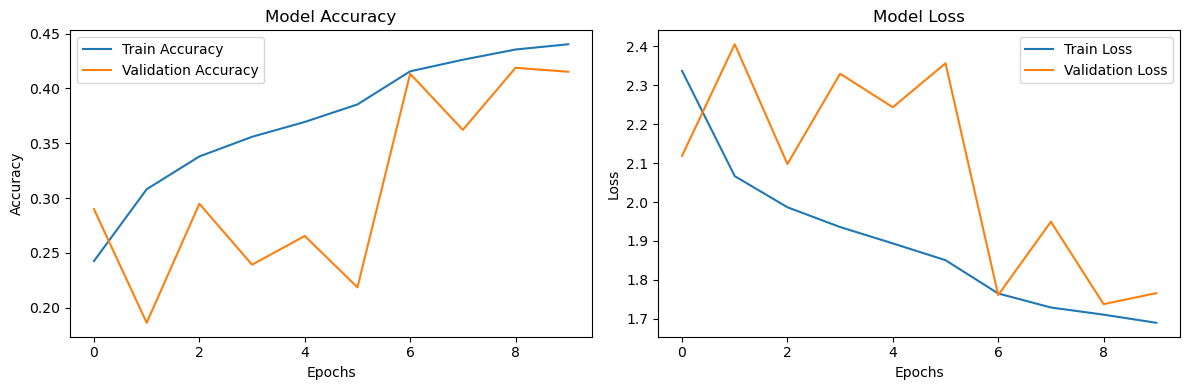

In [8]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Retrain et Unfreeze des dernières couches

In [8]:
# retrain_model = model
retrain_model = load_model('./model/resnet50_14_classes.h5')

checkpoint = ModelCheckpoint(
    './model/resnet50_14_classes.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

for layer in retrain_model.layers[-10:]:  # For example, unfreezing the last 10 layers
    layer.trainable = True

In [9]:
retrain_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

In [10]:
history = retrain_model.fit(
    train_generator,
    steps_per_epoch = nb_img_train//batch_size,
    validation_data = val_generator,
    validation_steps = nb_img_val//batch_size,
    epochs=5,
    callbacks=[early_stopping, checkpoint, reduce_lr, time_callback]
)

# Save the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('resnet50_15_epoch_training_history.csv', index=False)

Epoch 1/5


2024-10-09 18:37:40.047194: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-10-09 18:37:40.901569: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-10-09 18:37:41.012590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 71368704 exceeds 10% of free system memory.
2024-10-09 18:37:41.102166: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-10-09 18:37:41.134949: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.


575/575 [==============================] - ETA: 0s - loss: 1.6536 - accuracy: 0.4529

/home/matis/miniconda3/envs/rakuten_matis/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 duration: 2441.10 seconds
575/575 [==============================] - 2441s 4s/step - loss: 1.6536 - accuracy: 0.4529 - val_loss: 1.7193 - val_accuracy: 0.4343 - lr: 1.0000e-04
Epoch 2/5
575/575 [==============================] - 2030s 4s/step - loss: 1.6382 - accuracy: 0.4560 - val_loss: 1.6953 - val_accuracy: 0.4380 - lr: 1.0000e-04
Epoch 3/5
575/575 [==============================] - 1578s 3s/step - loss: 1.6192 - accuracy: 0.4666 - val_loss: 1.7233 - val_accuracy: 0.4305 - lr: 1.0000e-04
Epoch 4/5
575/575 [==============================] - 1571s 3s/step - loss: 1.6036 - accuracy: 0.4702 - val_loss: 1.7199 - val_accuracy: 0.4364 - lr: 1.0000e-04
Epoch 5/5
575/575 [==============================] - 1565s 3s/step - loss: 1.5862 - accuracy: 0.4749 - val_loss: 1.6947 - val_accuracy: 0.4371 - lr: 1.0000e-04
Total training duration: 9186.40 seconds


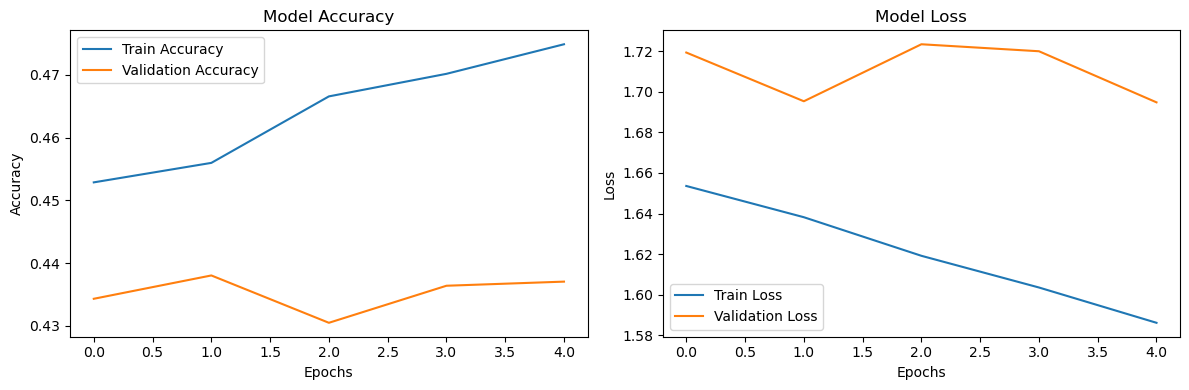

In [11]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Inspect model

In [12]:
new_model = retrain_model

In [15]:
# reverse_product_dict = {v: k for k, v in product_dict.items()}
# sorted_labels = sorted(train_generator.class_indices, key=train_generator.class_indices.get)

# mapped_labels = [product_dict[reverse_product_dict[label]] for label in sorted_labels]

reverse_generalized_dict = {v: k for k, v in generalized_dict.items()}
sorted_labels = sorted(train_generator.class_indices, key=train_generator.class_indices.get)

mapped_labels = [generalized_dict[reverse_generalized_dict[label]] for label in sorted_labels]

In [16]:
group = df.groupby('prdtypecode').head(150)  # This will get the first 50 elements per 'prdtypecode'

# Extract image paths and labels for these 50 samples per 'prdtypecode'
X_train = group['image_path']
y_train = group['prdtypecode']

# Prepare prediction and true label arrays (make sure they match the size of the filtered dataset)
y_pred = np.zeros(len(group))
y_train_arr = np.zeros(len(group))

# Loop through the filtered dataset to perform predictions
for i in range(len(group)):
    # Map 'prdtypecode' to corresponding label index using mapped_labels
    y_train_arr[i] = mapped_labels.index(group.iloc[i].prdtypecode)

    # Read and preprocess the image
    im = plt.imread(group.iloc[i].image_path)
    im = resize(im, (128, 128, 3), anti_aliasing=True)
    im_batch = np.expand_dims(im, axis=0)  # Expand dimensions to match batch input

    # Predict using the model
    pred = new_model.predict(im_batch, verbose=False)

    # Store the predicted class (argmax of predictions)
    y_pred[i] = np.argmax(pred[0])

In [17]:
# Calculate and print classification metrics
print("Accuracy:", accuracy_score(y_train_arr, y_pred))

Accuracy: 0.4204761904761905


In [18]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_train_arr, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.69      0.56       150
         1.0       0.32      0.33      0.33       150
         2.0       0.43      0.37      0.39       150
         3.0       0.68      0.33      0.44       150
         4.0       0.23      0.54      0.33       150
         5.0       0.24      0.37      0.29       150
         6.0       0.82      0.62      0.70       150
         7.0       0.66      0.25      0.36       150
         8.0       0.35      0.28      0.31       150
         9.0       0.86      0.08      0.15       150
        10.0       0.34      0.45      0.39       150
        11.0       0.44      0.31      0.37       150
        12.0       0.86      0.79      0.83       150
        13.0       0.36      0.47      0.41       150

    accuracy                           0.42      2100
   macro avg       0.50      0.42      0.42      2100
weighted avg       0.50      0.42      0.42      2100



In [19]:
# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train_arr, y_pred))


Confusion Matrix:
[[104   5   8   0   4   3   2   0   1   0   2   2   6  13]
 [  8  49  19   2   9  13   3   5  13   1  13   1   1  13]
 [ 29  11  55   2   8   6   1   1   5   0   6   3   7  16]
 [  8  17   8  49  13  10   1   0   5   0  14   5   0  20]
 [  4   2   3   2  81  25   2   3   8   0   9   5   0   6]
 [  4   3   1   1  39  56   6   0   8   0  12  11   1   8]
 [  3   1   1   0  12  32  93   0   3   0   2   1   0   2]
 [  0  11   3   1  30  26   2  37   2   0  18   3   0  17]
 [  3  17  12   1  28  16   0   0  42   0  14  10   0   7]
 [  3  15   2   6  39  20   2   5  13  12  21   3   1   8]
 [  4   2   4   3  32  15   1   2   4   0  68   9   0   6]
 [ 16   5   5   3  34  10   1   0  13   0   9  47   2   5]
 [ 19   3   2   0   0   1   0   0   0   0   1   0 119   5]
 [ 18  10   6   2  19   1   0   3   3   1   9   6   1  71]]


1/1 [==============================] - 0s 94ms/step
y_pred : trading card games - y_test : video games and consoles 
class index : 12 - conf score: 0.31514203548431396



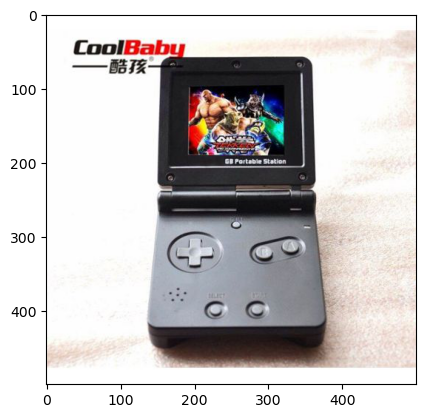

In [38]:
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import random

i = random.randint(5,1000)
# Load the image
im_test = plt.imread(df.image_path[i])

# Resize the image to 128x128 and ensure 3 channels
im_test_resized = resize(im_test, (128, 128, 3), anti_aliasing=True)

im_test_batch = np.expand_dims(im_test_resized, axis=0)

# Predict with the model
predictions = new_model.predict(im_test_batch)
print(f'y_pred : {mapped_labels[np.argmax(predictions[0])]} - y_test : {df.prdtypecode[i]} \nclass index : {np.argmax(predictions[0])} - conf score: {max(predictions[0])}\n')
plt.imshow(im_test)
plt.show()